In [266]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


### Name : Bharadwaj Tippavajjula
### Email : bharadwaj1492@gmail.com
### Questions in Red and Answers in Green

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('bmh')

In [70]:
df = pd.read_csv('./data_science_screening_exercise_orders.csv')

In [71]:
df.head()
df['date'] = pd.to_datetime(df['date'])

#####  <font color = 'green' >  Running Validation tests on dataset for any anomalies </font>

In [19]:
##### Testing to see if a user is mapped to multiple genders 
tempdf = df.groupby('customer_id')['gender'].agg('nunique').reset_index()
assert tempdf.query('gender > 1').shape[0] == 0 , "There are users where single customer is mapped to multiple genders"

In [196]:
print("We have data for ", df.customer_id.nunique() ,"unique customers" ,"\nMax date is " , df.date.min(), "and min date is " , df.date.min())

We have data for  8814 unique customers 
Max date is  2017-01-01 00:11:31 and min date is  2017-01-01 00:11:31


In [261]:
print("removing duplicate rows")
df.drop_duplicates(inplace = True)

removing duplicate rows


#####  <font color = 'red'> A) Assemble a dataframe with one row per customer and the following columns: </font>
#####  <font color = 'red'> customer_id </font>
#####  <font color = 'red'> gender </font>
#####  <font color = 'red'> most_recent_order_date </font>
#####  <font color = 'red'> order_count (number of orders placed by this customer) </font>

In [265]:
customer_view = df.groupby(['customer_id'])['gender','date'].agg({'gender' : 'max'
                                                                  ,"date":['max','count']
                                                                }).reset_index()
customer_view.columns = ['customer_id','gender','most_recent_order_date','order_count']
print("priting random 20 customers")
customer_view.head(20)


priting random 20 customers


#####  <font color = 'red' > B) Plot the count of orders per week </font>

<IPython.core.display.Javascript object>


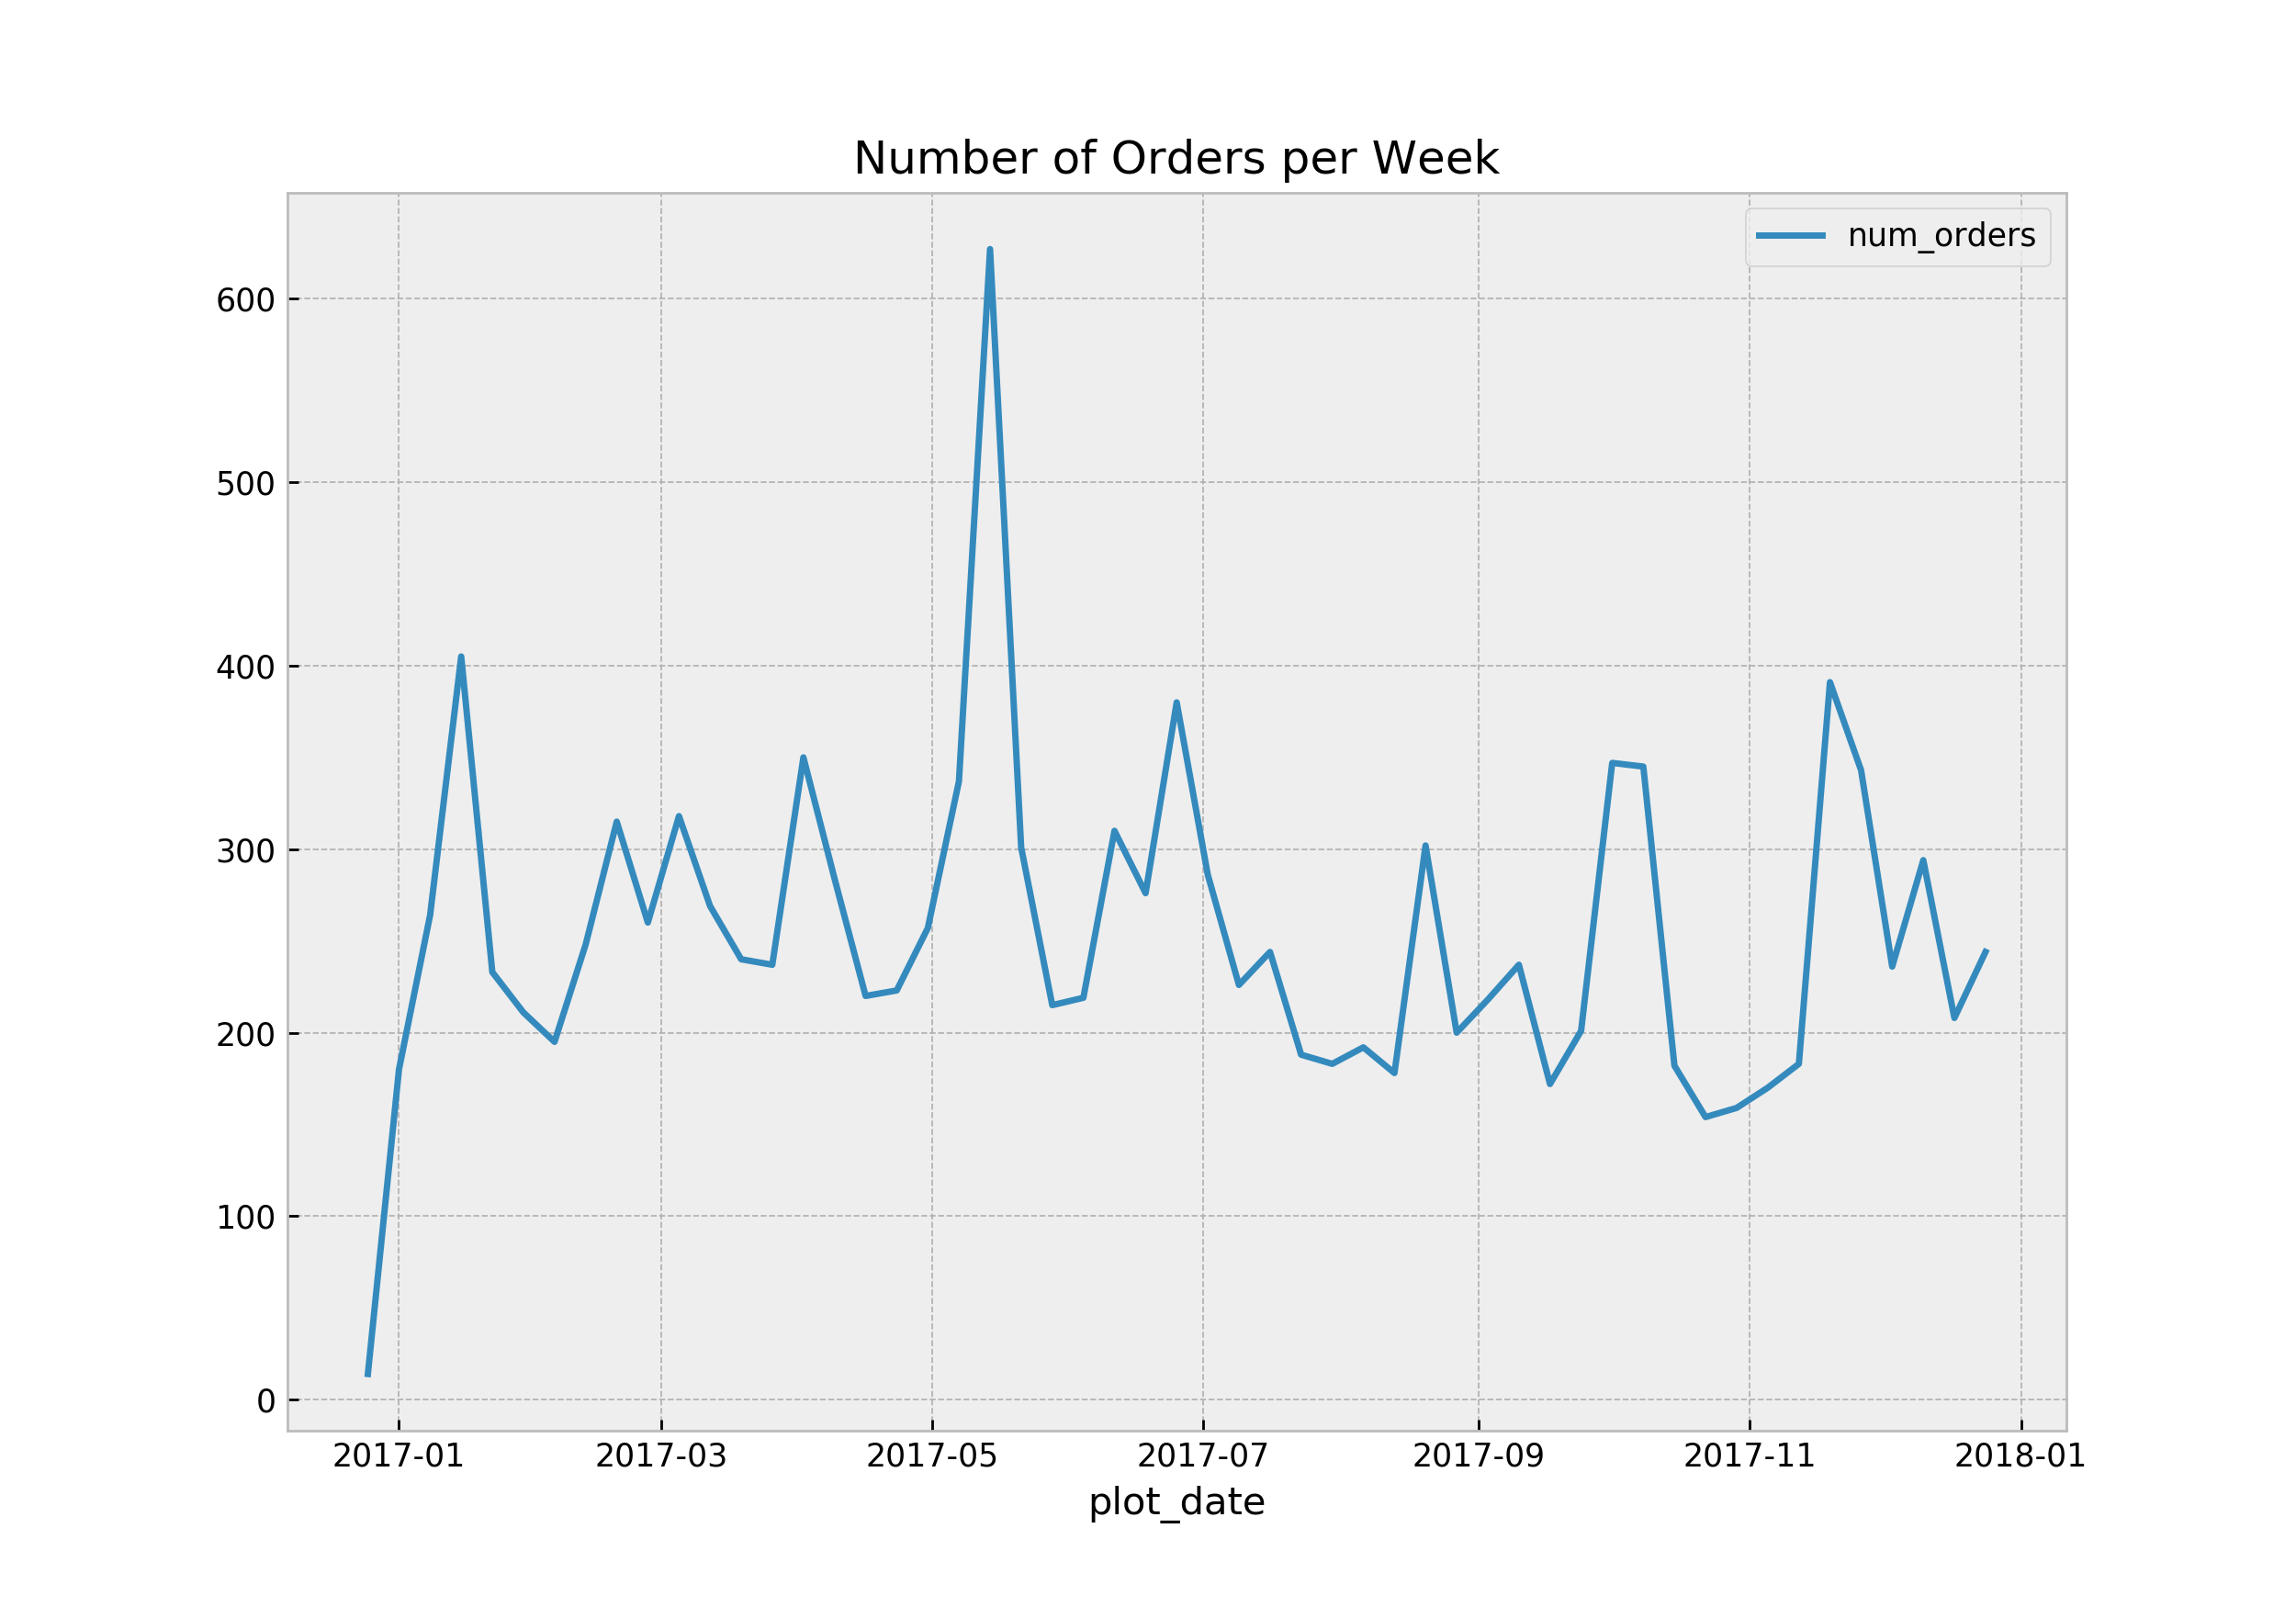

In [130]:
orders_weekly_view = df.copy(deep= True)
orders_weekly_view['date'] = orders_weekly_view['date'] - pd.to_timedelta(7, unit='d')
orders_weekly_view = orders_weekly_view.groupby([pd.Grouper(key='date', freq='W-SUN')])['customer_id'].count().reset_index().sort_values('date')
orders_weekly_view.columns = ['plot_date','num_orders']
orders_weekly_view['plot_date'] = orders_weekly_view['plot_date'].map(lambda x : x.date())
orders_weekly_view.index = orders_weekly_view.plot_date
fig , ax = plt.subplots(1,1)
fig.set_size_inches(10,7)
orders_weekly_view.plot(title = 'Number of Orders per Week', ax = ax)
plt.show()

##### <font color = 'red'> C) Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant? </font>

In [127]:
df.groupby('gender').value.describe()

#####  <font color = 'green'>  We see from the above table that Mean of Gender 0 is 363.89 and Mean of Gender 1 is 350.708 </font>
##### <font color = 'green'> Null Hypothesis : Mean of Gender 0 = Mean of Gender 1 </font>
##### <font color = 'green'> Alternate Hypothesis : Mean of Gender 0 != Mean of Gender 1 </font>
##### <font color = 'green'> Assuming significance level (Probability of Type 1 Error) to be 0.05 

<IPython.core.display.Javascript object>


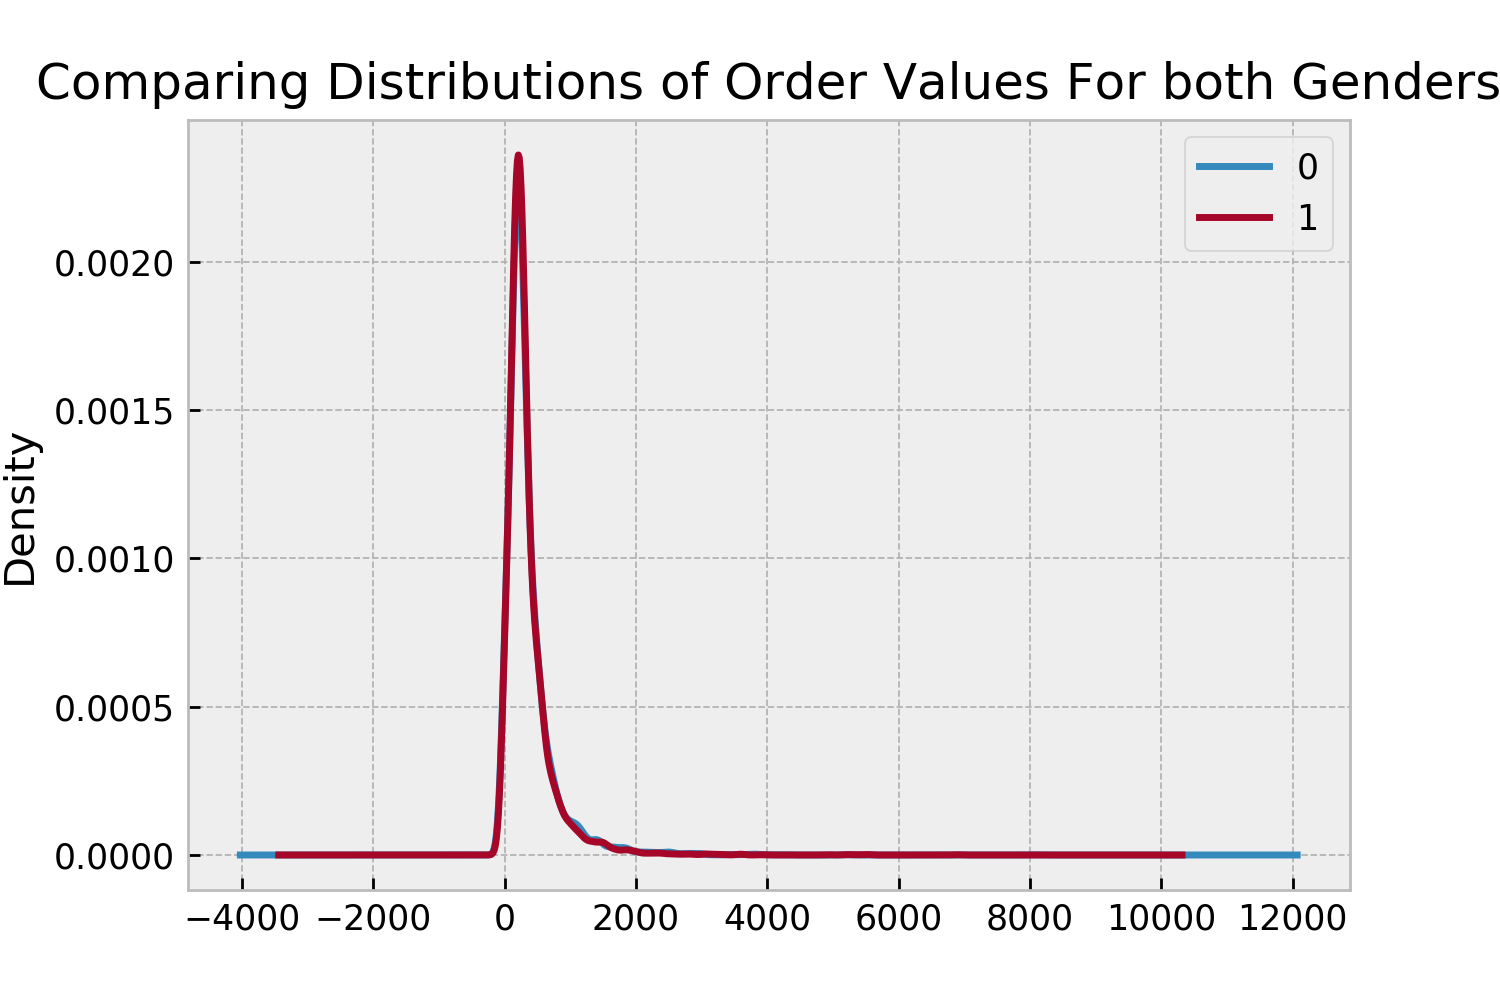

Text(0.5,1,'Comparing Distributions of Order Values For both Genders')

In [254]:
fig , ax = plt.subplots(1,1)
fig.set_size_inches(6,4)
grouped_df = df.groupby('gender')
for group_name, data in grouped_df:
    data['value'].plot(kind='kde', label = group_name)
ax.legend()
plt.title("Comparing Distributions of Order Values For both Genders")

#####  <font color = 'green' > The Distributions show that data is highly Right Skewed and so we need to test Normality assumption on the data before confirming any test </font>

In [149]:
###### Lets first run a Normal test on the data 
from scipy.stats import normaltest
print("Normality test for Gender Group 1 ", stats.normaltest(df.query('gender==1')['value']), "\nNormality test for Gender Group 0", stats.normaltest(df.query('gender==1')['value']))

Normality test for Gender Group 1  NormaltestResult(statistic=6848.7592806874945, pvalue=0.0) 
Normality test for Gender Group 0 NormaltestResult(statistic=6848.7592806874945, pvalue=0.0)


In [234]:
##### Lets try the test again by removing outliers 
q1 = df['value'].quantile(0.25)
q3 = df['value'].quantile(0.75)
iqr = q3-q1
print("Normality test by Removing outliers using 1.5*IQR technique = "
      ,stats.normaltest(
              df.query('(@q1 -1.5*@iqr) <= value <= (@q3+1.5*@iqr)')['value']
      )
     )

Normality test by Removing outliers using 1.5*IQR technique =  NormaltestResult(statistic=1163.3101381853735, pvalue=2.457045064908226e-253)


#####  <font color = 'green' > Conducting Anderson and Darling Test for Checking if the Data is Normal  as the above test failed  for confimration </font>

In [236]:
from scipy.stats import anderson 
anderson(df['value'], dist ='norm')

AndersonResult(statistic=1056.299529826867, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

#####  <font color = 'green' > Log Transformed Distribution of Value </font>

<IPython.core.display.Javascript object>


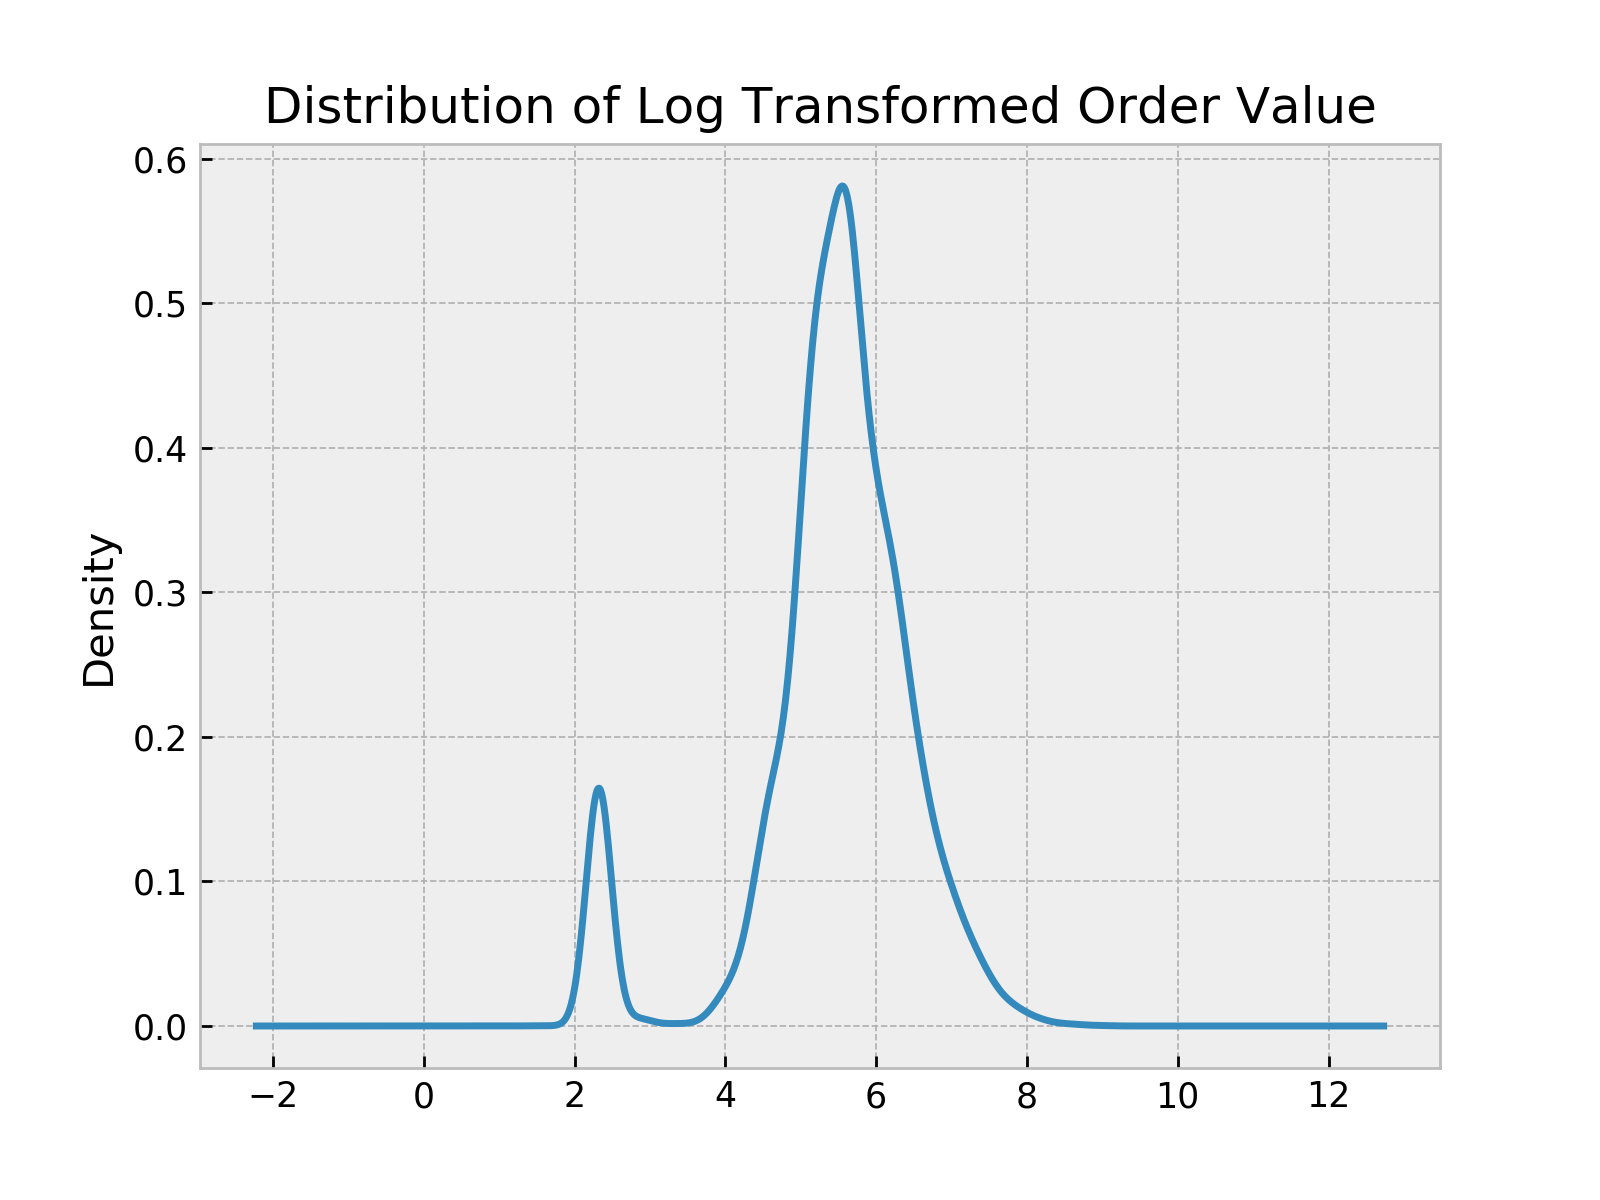

In [284]:
np.log(df.query('value>1').value).plot(kind = 'kde', title = 'Distribution of Log Transformed Order Value')

######  <font color = 'green' > Both tests confirm that data does not follow a Normal Distribution </font> 
######  <font color = 'green' > The Log Transformation led to Bimodal Distribution and so it also fails to convert data to Normal distribution. So, we cannot use Independent Two Sample T Test </font>
#####  <font color = 'green' > Using Non Parameteric  KS (Kolmogorov-Smirnov ) Test to  check if the distributions are different </font>

In [248]:
from scipy.stats import ks_2samp
ks_2samp( df.query('gender==0')['value'], df.query('gender==1')['value'])

Ks_2sampResult(statistic=0.019339022829402697, pvalue=0.15929713444758967)

#####  <font color = 'green' > Since the KS test Failed to show any difference in data distributions, we can proceed with Non Parametric Mann Whitney U Test - A non parametric version of T-Test of Independent means </font>

In [255]:
from scipy.stats import mannwhitneyu
mannwhitneyu(df.query('gender==0')['value'], df.query('gender==1')['value'])

MannwhitneyuResult(statistic=22451444.5, pvalue=0.15220525508505944)

##### <font color = 'green' > Mann Whitney U Test failed to show difference between two means 

#####  <font color = 'green' > Test Results : </font>
#####  <font color = 'green' > Mann Whitney U Test both donot show significant difference between the means at Significance Level of 0.05 </font>
#####  <font color = 'green' > Conclusion :  Since the test failed to reject the Null hypothesis, We cannot conclude if there is a significance difference between the Mean value of orders between two Gender groups. So  </font> 